In [8]:
from read_alf import Alf
import matplotlib.pyplot as plt
import numpy as np
import pyphot
from matplotlib import gridspec
from astropy.io import fits
from scipy import interpolate

/var/folders/cd/b14jxcv1623c49mdlsjf5gj80000gn/T/ipykernel_12452/1205927036.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


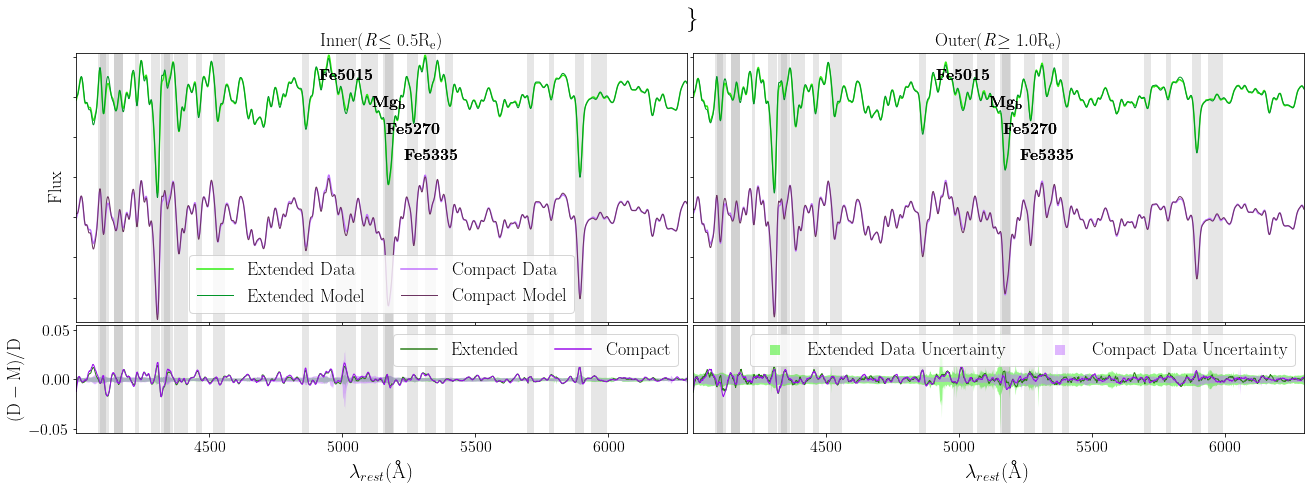

In [16]:
split_type = ['m20kpc_v_sigmacen', 'm10kpc_v_m20kpc_control']
i=1
path = '../data/alf/'
save_path='../plots/'
alfnames = ['high_nomask_in', 'low_nomask_out']
label_names = ['high', 'low']
radius_names = ['in', 'out']
radii_labels = [r'$\mathrm{Inner(}\mathit{R}\mathrm{\le 0.5R_e)}$',
                r'$\mathrm{Outer(}\mathit{R}\mathrm{\ge 1.0R_e)}$']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Charter",
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "axes.labelsize": 18,
    "axes.labelweight": "bold"
})
names = ['Hdelta_A', 'Hdelta_F', 'CN_1', 'CN_2', 'Ca4227',
         'G4300', 'Hgamma_A', 'Hgamma_F', 'Fe4383',
         'Ca4455', 'Fe4531', 'H_beta', 'Fe5015',
         'Mg_1', 'Mg_2', 'Mg_b', 'Fe5270', 'Fe5335', 'Fe5406',
         'Fe5709', 'Fe5782', 'Na_D', 'TiO_1']
chosen_names = {'Fe5015': 'Fe5015','Mg_b': 'Mgb', 'Fe5270': 'Fe5270', 'Fe5335': 'Fe5335'}
names_label = np.array([r'$\mathbf{Fe5015}$', r'$\mathbf{Mg_b}$', r'$\mathbf{Fe5270}$', r'$\mathbf{Fe5335}$'])
l = pyphot.LickLibrary()

flux_lim = [0.74, 1.41]

titles = r'$\mathrm{Compact\ vs.\ Extended}$'

fig = plt.figure(figsize=(22, 7), clear=True)
spec = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1, 1], height_ratios=[2.5, 1], hspace=0.02, wspace=0.01)
ax_spec = [fig.add_subplot(spec[0, 0]), fig.add_subplot(spec[0, 1])]
ax_diff = [fig.add_subplot(spec[1, 0]), fig.add_subplot(spec[1, 1])]
err_color = ['red', 'blue']

model_colors = ['xkcd:irish green', 'xkcd:grape']
data_colors = ['xkcd:vivid green', 'xkcd:easter purple']
diff_colors = ['xkcd:tree green', 'xkcd:violet']
sample_labels = [r'$\mathrm{Extended}$', r'$\mathrm{Compact}$']

for j in range(len(label_names)):
    std = fits.open(path +split_type[i] + '/'+ 'std_' + split_type[i] + '_total_' + label_names[j] + '.fits')
    for k in range(len(radius_names)):
        myalf = Alf(
            path + split_type[i] + '/' + label_names[j] + '_' + split_type[i] + '_median_' + radius_names[k])
        myalf.get_total_met()
        myalf.normalize_spectra()

        wave = myalf.spectra['wave']
        wave_skip = [wave <= 4979, wave >= 5070]
        wave_lim = [wave[0], wave[-1]]
        # ax_spec = brokenaxes(xlims=((4000, 6300), (8000,8700)), subplot_spec=spec[0], wspace=.02)
        # ax_diff = brokenaxes(xlims=((4000, 6300), (8000,8700)), subplot_spec=spec[1], wspace=.02)#fig.add_subplot(spec[1])

        for name in names:
            fk = l[name]
            ax_spec[k].axvspan(fk.band.magnitude[0], fk.band.magnitude[1], ymin=0, ymax=1,
                               edgecolor=None, facecolor='grey', alpha=0.1)
            ax_diff[k].axvspan(fk.band.magnitude[0], fk.band.magnitude[1], ymin=0, ymax=1,
                               edgecolor=None, facecolor='grey', alpha=0.1)

            if [*chosen_names].__contains__(name):
                idx_tmp = np.where(np.array([*chosen_names]) == fk.name)[0][0]

                ax_spec[k].text((fk.band.magnitude[0] + fk.band.magnitude[1]) / 2,
                                flux_lim[0] + (0.9 - 0.1 * idx_tmp) * (flux_lim[1] - flux_lim[0]),
                                names_label[idx_tmp],
                                ha='center', fontsize=16)

        func_std = interpolate.interp1d(std['wave'].data, std['std_' + radius_names[k]].data)

        # std_mask = (std['wave'].data >= wave[0]) & (std['wave'].data <= wave[-1])
        std_mask = (wave >= std['wave'].data[0]) & (wave <= std['wave'].data[-1])
        ax_diff[k].fill_between(myalf.spectra['wave'][std_mask],
                                (-3 * func_std(myalf.spectra['wave'][std_mask])) / myalf.spectra['d_flux_norm'][
                                    std_mask],
                                (3 * func_std(myalf.spectra['wave'][std_mask])) / myalf.spectra['d_flux_norm'][
                                    std_mask],
                                color=data_colors[j], lw=0, alpha=0.5)

        ax_spec[k].plot(myalf.spectra['wave'], myalf.spectra['d_flux'] + (1 - j) * 0.3, '-', color=data_colors[j],
                        lw=1.4)
        ax_spec[k].plot(myalf.spectra['wave'], myalf.spectra['m_flux'] + (1 - j) * 0.3, '-', color=model_colors[j],
                        lw=1)

        ax_diff[k].plot(myalf.spectra['wave'],
                        (myalf.spectra['d_flux'] - myalf.spectra['m_flux']) / myalf.spectra['d_flux'],
                        '-', color=diff_colors[j], lw=1)

        ax_spec[k].set_ylim(flux_lim)

        ax_diff[k].set_xlabel(r'$\lambda_{rest}(\mathrm{\AA})$', fontsize=20)

        ax_spec[k].set_xlim(wave_lim)
        ax_diff[k].set_xlim(wave_lim)
        ax_spec[k].set_xticklabels([])
        ax_spec[k].set_yticklabels([])
        # ax_spec[k].yaxis.set_visible(False)

        if k != 0:
            ax_spec[k].sharey(ax_spec[0])
            ax_diff[k].yaxis.set_visible(False)
            ax_diff[k].sharey(ax_diff[0])

        ax_spec[k].set_title(radii_labels[k], fontsize=18)

    ax_spec[0].plot([], [], color=data_colors[j], lw=1.5, label=sample_labels[j] + r'$\mathrm{\ Data}$')
    ax_spec[0].plot([], [], color=model_colors[j], lw=1.0, label=sample_labels[j] + r'$\mathrm{\ Model}$')
    ax_diff[0].plot([], [], color=diff_colors[j], label=sample_labels[j])
    ax_diff[1].scatter([], [], s=100, marker='s', edgecolor='None', facecolor=data_colors[j], alpha=0.5,
                       label=sample_labels[j] + r'$\mathrm{\ Data\ Uncertainty}$')

ax_spec[0].legend(ncol=2, fontsize=18)
ax_diff[0].legend(ncol=2, fontsize=18)
ax_diff[1].legend(ncol=2, fontsize=18)
ax_diff[0].set_ylabel(r'$\mathrm{(D-M)/D}$')
ax_spec[0].set_ylabel(r'$\mathrm{Flux}$')
ax_spec[1].text(-0., 1.1, titles[i], transform=ax_spec[1].transAxes, fontsize=25, ha='center')

fig.tight_layout()